In [6]:
from operator import le
import os
from textwrap import wrap
import numpy as np
import math

from scipy.sparse.linalg.dsolve.linsolve import use_solver
from preprocessing import *
import matplotlib.pyplot as plt
import pandas as pd
from utils import *
from copy import copy
from ekf_functions import *

# ICRA Imports
from adaptive_constraint_bound import *
from uwb_baseline_estimate import *
from barrier_function import *

In [7]:
cwd = os.getcwd()
dir_path = cwd[:-3]

###################### SETUP ######################
#- params -------------------------------------------
date = np.datetime64("2021-08-26")  # measurement date in YYYY-MM-DD
truth_frequency = 4                 # ground truth frequency 
obs_freq = 2                        # uwb / observation frequency
ksnr = 200
phase_ratio = 300 	                # sigma phase = sigma code / phase_ratio
f = 1575.42 * 10 ** 6
c = 299792458
lda = c / f

#- observation and grouth truth files ------------------
name_obs1 = dir_path + 'data/20210826_data_icra/leader2.21O'
name_obs2 = dir_path + 'data/20210826_data_icra/follower.21O' 
name_eph =  dir_path + 'data/20210826_data_icra/leader2.21N'

ground_truth = np.loadtxt(dir_path + 'data/20210826_data_icra/Ground_Truth_Static.csv', delimiter = ",")  # Format: [GPS Time, E, N, U] (Relative Coordinates)
uwb_data = np.loadtxt(dir_path + 'data/20210826_data_icra/UWB_Baseline_Static.csv', delimiter = ",")      # TODO: check the data format on this

In [8]:
#- preprocess-------------------------------------------
traj1, traj2, eph = loadTrajectories(name_obs1, name_obs2, name_eph)
print('trajectories loaded')

t_gps, svs, code1, code2, carrier1, carrier2, cnos, ts = constructMeasurements(traj1, traj2, date, sort_cn0 = False)
cnos = np.array(cnos)
print('measurements constructed')

gt_vels = []
for i in range(len(ground_truth) - 1):
    instvel = (ground_truth[i + 1, 1:3] - ground_truth[i, 1:3]) / (ground_truth[i + 1, 0] - ground_truth[i, 0])
    gt_vels.append(instvel)
gt_vels = np.array(gt_vels)
print('computed ground truth velocities')

#- for real-world data -------
gt_inds, obs_inds = match_times(ground_truth, t_gps)     
dt = ground_truth[gt_inds[1], 0] - ground_truth[gt_inds[0], 0]  
print('dt', dt)

#- for simulated trajectory ---
# dt = 1 / truth_frequency  

#- get list of all satellites that appear in run -----
svs_reshaped = np.concatenate(np.array(svs))
all_sats = np.unique(svs_reshaped)

trajectories loaded
measurements constructed
computed ground truth velocities
dt 0.5


<ipython-input-8-d54a6eaed4e3>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cnos = np.array(cnos)
<ipython-input-8-d54a6eaed4e3>:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  svs_reshaped = np.concatenate(np.array(svs))


Text(0, 0.5, 'Relative x [m]')

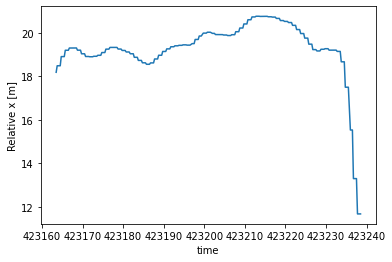

In [23]:
plt.figure()
plt.plot(ground_truth[:,0], ground_truth[:,1])
plt.xlabel('time')
plt.ylabel('Relative x [m]')

Text(0, 0.5, 'Relative y [m]')

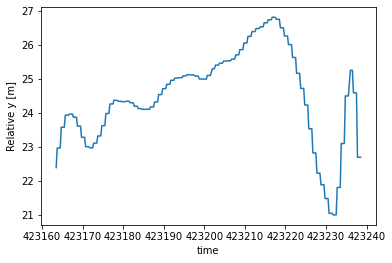

In [22]:
plt.plot(ground_truth[:,0], ground_truth[:,2])
plt.xlabel('time')
plt.ylabel('Relative y [m]')

In [9]:
def ekf_gnss_uwb_mm(state_curr, Sig_curr, y, dt, k, w, G, A, Q, R, svs_obs, sv2id, rescale=False):
    '''
    EKF for GNSS + UWB tight coupling with mismatched measurement vector depending on satellite visibility at each time
    step in the trajectory.
    '''
    nState = len(state_curr)
    nMeas = len(y)

    #- predict -----------------------
    state_t1, Sig_t1 = ekf_predict(state_curr, Sig_curr, dt, Q)

    #- update -----------------------
    # measurement jacobian [2k + w, 4 + k]
    H_uwb = uwb_measJac(nState, state_t1)
    H_gps = gps_measJac(nState, nMeas - w, G, A)
    H = np.concatenate((H_gps, H_uwb))
    meas_pred = H @ state_t1
    resid = y - meas_pred

In [5]:
np.random.seed(0)

################ INIT FILTER ###########################
ref_ind = np.argmax(cnos[obs_inds[0]][0:])
print('All SVS', all_sats)
print('ref sat', svs[obs_inds[0]][ref_ind])
print('ref CN0', cnos[obs_inds[0]][ref_ind])

K = len(all_sats) - 1       # total possible num. of unique DD measurements
w = 1                       # num of UWB range measurements
nState = 4 + K              # state vector size
nMeas = 2 * K + w           # measurement vector size

P_pre, Q, R, R_gps, sig_uwb = init_covariances(K, nState, nMeas, disp=True)
sv2id = id_map(all_sats)

init_x_e = ground_truth[gt_inds[0], 1]
init_x_n = ground_truth[gt_inds[0], 2]
init_v_e = gt_vels[gt_inds[0],0]
init_v_n = gt_vels[gt_inds[0],1]

# ##### simulated ######
# # init_x_e = ground_truth[seg_start_ind, 1]
# # init_x_n = ground_truth[seg_start_ind, 2]
# # init_v_e = gt_vels[seg_start_ind, 0]
# # init_v_n = gt_vels[seg_start_ind, 1]
# #####################

x_pre = np.zeros((nState, 1))
x_pre[0] = init_x_e + np.random.normal(0, math.sqrt(P_pre[0, 0]), 1)
x_pre[1] = init_x_n + np.random.normal(0, math.sqrt(P_pre[1, 1]), 1)
x_pre[2] = init_v_e + np.random.normal(0, math.sqrt(P_pre[2, 2]), 1)
x_pre[3] = init_v_n + np.random.normal(0, math.sqrt(P_pre[3, 3]), 1)
print('init', np.ndarray.flatten(x_pre))

x_pre_lambda = copy(x_pre)
P_pre_lambda = copy(P_pre)

x_pre_round = copy(x_pre)
P_pre_round = copy(P_pre)

x_pre_gps = copy(x_pre)
P_pre_gps = copy(P_pre)

# ################### MAIN LOOP #############################
truth = []
seg_svs = []

# est_round = []
# covars_round = []
# residuals_round = []
# error_round = []
# v_error_round = []
# est_round.append(np.ndarray.flatten(x_pre_round))
# covars_round.append(P_pre_round)


est_lambda = []
covars_lambda = []
residuals_lambda = []
Ps_vals = []
error_lambda = []
v_error_lambda = []
est_lambda.append(np.ndarray.flatten(x_pre_lambda))
covars_lambda.append(P_pre_lambda)


# est_gps = []
# covars_gps = []
# residuals_gps = []
# Ps_vals_gps = []
# error_gps = []
# v_error_gps = []
# est_gps.append(np.ndarray.flatten(x_pre_gps))
# covars_gps.append(P_pre_gps)


print('entering loop')

x0 = np.array([-2.7011e+06,-4.292e+06, 3.8554e+06]) # ECEF coords 
init_n = None

for i in range(0, len(gt_inds)):
    
    # get appropriate indices
    gt_ind = gt_inds[i]
    obs_ind = obs_inds[i]
    if ground_truth[gt_ind, 0] != t_gps[obs_ind]:
        print('Error: Misaligned timestamps.')
    
    ### for simulated traj ####
    # gt_ind = i
    # obs_ind = i
    ###########################
    
    # GROUND TRUTH
    truth_term = ground_truth[gt_ind, 1:]
    truth.append(truth_term[0:2])

    #- MEASUREMENTS -------------------------------------------------------------------------
    # gps
    svs_obs = svs[obs_ind]
    select_code1 = code1[obs_ind]
    select_code2 = code2[obs_ind]
    select_carrier1 = carrier1[obs_ind]
    select_carrier2 = carrier2[obs_ind]

    sigma_code, sigma_phase = sigmaFromCN0(cnos[obs_ind], ksnr, phase_ratio)
    psi, G, A, sigma = prepareData(t_gps[obs_ind], svs_obs, np.array(select_code1), np.array(select_code2), np.array(select_carrier1), np.array(select_carrier2), eph, plane=False, ref=ref_ind, x0=x0, f=1575.42*10**6, phase_error=0.025)
    k = psi.shape[0] // 2                                       # number of DD measurements in this time step
    H = np.zeros((2 * k, G.shape[1]))
    H[:k] = G
    H[k:] = G
    psi -= truth_term[2] * H[:, 2]
    H = H[:, :2]
    print(len(svs_obs) - 1)
    print(H.shape)
    print(A.shape)

    # uwb
    uwb_range = uwb_meas(truth_term[0:2]) + np.random.normal(0, sig_uwb, 1)
    # uwb_range = uwb_data[gt_ind, 0]

    # construct meas vec
    y = np.reshape(np.append(psi, uwb_range), (2 * k + w, 1))
    # y_gps = np.reshape(psi, (2 * k, 1))                       # gps only measurement vector


    # - FILTERING ----------------------------------------------------------------
    # x_next_lambda, P_next_lambda, resid_lambda = ekf_gnss_uwb_mm(x_pre_lambda, P_pre_lambda, y, dt, k, w, H, A, Q, R)
    x_next_round, P_next_round, resid_round = ekf_gnss_uwb(x_pre_round, P_pre_round, y, dt, k, w, H, A, Q, R)
    # x_next_gps, P_next_gps, resid_gps = ekf_gnss(x_pre_gps, P_pre_gps, y_gps, dt, k, H, A, Q, R_gps)

#     # LAMBDA
#     fixed_pos, afixed, Ps = lambda_positionFix(np.ndarray.flatten(x_next_lambda[4:]), sigma, psi, k, lda, H, A)
#     fixed_pos = np.reshape(fixed_pos, (2, 1))
#     x_next_lambda[0:2] = fixed_pos
#     x_next_lambda[4:] = np.reshape(afixed, (K, 1))
#     Ps_vals.append(Ps)

#     # Rounding
#     round_pos, around = round_positionFix(x_next_round[4:], psi, k, lda, H)   
#     round_pos = np.reshape(round_pos, (2, 1))
#     x_next_round[0:2] = round_pos
#     x_next_round[4:] = np.reshape(around, (K, 1))

#     # GPS Only
#     fixed_pos_gps, afixed_gps, Ps_gps = lambda_positionFix(np.ndarray.flatten(x_next_gps[4:]), sigma, psi, k, lda, H, A)
#     fixed_pos_gps = np.reshape(fixed_pos_gps, (2, 1))
#     x_next_gps[0:2] = fixed_pos_gps
#     x_next_gps[4:] = np.reshape(afixed_gps, (K,1))
#     Ps_vals_gps.append(Ps_gps)


#     #- STORE ----------------------------------------------------------------
#     err_lambda = truth_term[0:2] - np.ndarray.flatten(x_next_lambda[0:2])
#     v_err_lambda = gt_vels[gt_ind] - np.ndarray.flatten(x_next_lambda[2:4])

#     err_round = truth_term[0:2] - np.ndarray.flatten(x_next_round[0:2])
#     v_err_round = gt_vels[gt_ind] - np.ndarray.flatten(x_next_round[2:4])

#     err_gps = truth_term[0:2] - np.ndarray.flatten(x_next_gps[0:2])
#     v_err_gps = gt_vels[gt_ind] - np.ndarray.flatten(x_next_gps[2:4])

 
#     est_lambda.append(np.ndarray.flatten(x_next_lambda))
#     covars_lambda.append(P_next_lambda)
#     error_lambda.append(err_lambda)
#     v_error_lambda.append(v_err_lambda)
#     residuals_lambda.append(np.ndarray.flatten(resid_lambda))

#     x_pre_lambda = copy(x_next_lambda)
#     P_pre_lambda = copy(P_next_lambda)

#     est_round.append(np.ndarray.flatten(x_next_round))
#     covars_round.append(P_next_round)
#     error_round.append(err_round)
#     v_error_round.append(v_err_round)
#     residuals_round.append(np.ndarray.flatten(resid_round))
    
#     x_pre_round = copy(x_next_round)
#     P_pre_round = copy(P_next_round)

#     est_gps.append(np.ndarray.flatten(x_next_gps))
#     covars_gps.append(P_next_gps)
#     error_gps.append(err_gps) 
#     v_error_gps.append(v_err_gps)
#     residuals_gps.append(np.ndarray.flatten(resid_gps))

#     x_pre_gps = copy(x_next_gps)
#     P_pre_gps = copy(P_next_gps)

# print ('code done')




All SVS ['G08' 'G10' 'G18' 'G21' 'G23' 'G24' 'G27' 'G32']
ref sat G10
ref CN0 51.0
P: sig E [3], sig N [3], sig VE [5], sig VN [5], sig Int [50]
Q: sig E [5], sig N [5], sig VE [10], sig VN [10], sig Int [2]
R: sig UWB [1], sig Phi [0.01], sig Rho [10]
init [23.48215704 23.58747163  6.09368992 13.512466    0.          0.
  0.          0.          0.          0.          0.        ]
entering loop
7
(14, 2)
(14, 7)


TypeError: ekf_gnss_uwb_mm() missing 2 required positional arguments: 'svs_obs' and 'sv2id'

In [ ]:
# ################### PLOTTING ####################
truth = np.array(truth)
Ps_vals = np.array(Ps_vals)
Ps_vals_gps = np.array(Ps_vals_gps)

est_lambda = np.array(est_lambda)
est_lambda_ints = np.array(est_lambda[:, 4:])
error_lambda = np.array(error_lambda)
v_error_lambda = np.array(v_error_lambda)
covars_lambda = np.array(covars_lambda)
residuals_lambda = np.array(residuals_lambda)

est_round = np.array(est_round)
error_round = np.array(error_round)
v_error_round = np.array(v_error_round)
covars_round = np.array(covars_round)
residuals_round = np.array(residuals_round)

est_gps = np.array(est_gps)
est_gps_ints = np.array(est_gps[:, 4:])
error_gps = np.array(error_gps)
v_error_gps = np.array(v_error_gps)
covars_gps = np.array(covars_gps)
residuals_gps = np.array(residuals_gps)


df = pd.DataFrame(est_lambda)
df.to_csv(cwd + '/output/est_lambda.csv')

df = pd.DataFrame(est_lambda_ints)
df.to_csv(cwd + '/output/est_lambda_ints.csv')

df_rlamb = pd.DataFrame(residuals_lambda)
df_rlamb.to_csv(cwd + '/output/est_lambda_resids.csv')

df = pd.DataFrame(est_gps_ints)
df.to_csv(cwd + '/output/est_gps_ints.csv')

df_rgps = pd.DataFrame(residuals_gps)
df_rgps.to_csv(cwd + '/output/residuals_gps.csv')

df = pd.DataFrame(est_round)
df.to_csv(cwd + '/output/est_round.csv')

df = pd.DataFrame(Ps_vals)
df.to_csv(cwd + '/output/Ps.csv')

df = pd.DataFrame(Ps_vals_gps)
df.to_csv(cwd + '/output/Ps_gps.csv')

df_rround = pd.DataFrame(residuals_round)
df_rround.to_csv(cwd + '/output/residuals_rounding.csv')

start_plot_ind = 15


print('\n')

print('Err E. Avg: Lambda', np.mean(error_lambda[start_plot_ind:, 0]))
print('Err E. Max: Lambda', max(error_lambda[start_plot_ind:, 0]))
print('Err N. Avg: Lambda', np.mean(error_lambda[start_plot_ind:, 1]))
print('Err N. Max: Lambda', max(error_lambda[start_plot_ind:, 1]))

print('Err E. Avg: GPS', np.mean(error_gps[start_plot_ind:, 0]))
print('Err E. Max: GPS', max(error_gps[start_plot_ind:, 0]))
print('Err N. Avg: GPS', np.mean(error_gps[start_plot_ind:, 1]))
print('Err N. Max: GPS', max(error_gps[start_plot_ind:, 1]))

print('\n')

# position coord plots
plt.figure()
plt.title('GT vs. Est')
plt.plot(est_round[start_plot_ind:, 0], est_round[start_plot_ind:, 1])
plt.plot(est_lambda[start_plot_ind:, 0], est_lambda[start_plot_ind:, 1])
plt.plot(est_gps[start_plot_ind:, 0], est_gps[start_plot_ind:, 1])
plt.plot(truth[start_plot_ind:, 0], truth[start_plot_ind:, 1], 'k.')
plt.xlabel('East')
plt.ylabel('North')
plt.legend(['Round', 'Est. LAMBDA', 'GPS ONlY', 'Truth'])

plt.figure()
plt.title('East')
plt.plot(truth[start_plot_ind:, 0])
plt.plot(est_round[start_plot_ind:, 0])
plt.plot(est_lambda[start_plot_ind:, 0])
plt.plot(est_gps[start_plot_ind:, 0])
plt.legend(['Truth', 'Round', 'Est. LAMBDA', 'GPS ONlY'])

plt.figure()
plt.title('North')
plt.plot(truth[start_plot_ind:, 1])
plt.plot(est_round[start_plot_ind:, 1])
plt.plot(est_lambda[start_plot_ind:, 1])
plt.plot(est_gps[start_plot_ind:, 1])
plt.legend(['Truth', 'Round', 'Est. LAMBDA', 'GPS ONlY'])


# position error plot
plt.figure()
fig_err, ax_err = plt.subplots(2, 1)
for i in range(2):
    ax_err[i].plot(error_lambda[start_plot_ind:, i])
    ax_err[i].plot(error_gps[start_plot_ind:, i])
    ax_err[i].legend(['LAMBDA', 'GPS Only'])
ax_err[0].set_title('Position Error')
ax_err[1].set_xlabel('time')
ax_err[0].set_ylabel('error east [m]')
ax_err[1].set_ylabel('error north [m]')

# velocity error plot
plt.figure()
fig_v_err, ax_v_err = plt.subplots(2, 1)
for i in range(2):
    ax_v_err[i].plot(v_error_lambda[start_plot_ind:, i])
    ax_v_err[i].plot(v_error_gps[start_plot_ind:, i])
    ax_v_err[i].legend(['LAMBDA', 'GPS Only'])
ax_v_err[0].set_title('Velocity Error')
ax_v_err[1].set_xlabel('time')
ax_v_err[0].set_ylabel('error V East [m / s]')
ax_v_err[1].set_ylabel('error V North [m / s]')

# integer ambiguities
plt.figure()
for i in range(K):
    plt.figure()
    plt.plot(est_round[start_plot_ind:, i + 4])
    plt.plot(est_lambda[start_plot_ind:, i + 4])
    plt.plot(est_gps[start_plot_ind:, i + 4])
    plt.title('Integers')
    plt.legend(['Round', 'LAMBDA', 'GPS Only'])


# Position covariances
plt.figure()
plt.title('Covariance East and North')
plt.plot(covars_lambda[:, 0, 0])
plt.plot(covars_lambda[:, 1, 1])
plt.plot(covars_gps[:, 0, 0])
plt.plot(covars_gps[:, 1, 1])
plt.xlabel('Time')
plt.ylabel('$\sigma^{2}$')
plt.legend(['LAMB E', 'LAMB N', 'GPS E', 'GPS N'])

# Velocity covariances
plt.figure()
plt.title('Covariance Velocity')
plt.plot(covars_lambda[:,2,2])
plt.plot(covars_lambda[:,3,3])
plt.plot(covars_gps[:,2,2])
plt.plot(covars_gps[:,3,3])
plt.xlabel('Time')
plt.ylabel('$\sigma^{2}$')
plt.legend(['Lamb $v_{e}$', 'Lamb $v_{n}$', 'GPS $v_{e}$', 'GPS $v_{n}$'])

# integer ambiguities covariances
plt.figure()
fig_covSat, ax_covSat = plt.subplots(K, 1)
for i in range(K):
    ax_covSat[i].plot(covars_lambda[:, i + 4, i + 4])
    ax_covSat[i].plot(covars_gps[:, i + 4, i + 4])
    ax_covSat[i].set_ylabel('$\sigma^{2}$')
ax_covSat[0].set_title('Covariance Int Amb.')
ax_covSat[0].legend(['Lambda', 'GPS'])
ax_covSat[-1].set_xlabel('time')

